In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#### Setup Inicial

In [63]:
meds_train_alunos = pd.read_csv('../data/meds_train_alunos.csv')
meds_train_alunos.head()

,ponto_id,rssi_1_1,rssi_1_2,rssi_1_3,rssi_2_1,rssi_2_2,rssi_2_3,rssi_3_1,rssi_3_2,rssi_3_3,delay_1,delay_2,delay_3,lat,lon,indoor
0,6604,-103.705000,-110.425000,-107.381667,-110.330000,-108.345000,-106.590000,-107.153333,-102.120000,-115.00,5.0,3.0,2.0,-8.055786,-34.951505,True
1,5515,-105.225000,-115.000000,-105.210000,-115.000000,-105.835000,-115.000000,-88.470000,-94.024286,-108.12,5.0,3.0,2.0,-8.055784,-34.951608,True
2,5049,-102.610000,-115.000000,-101.380000,-115.000000,-104.295000,-97.360000,-96.980000,-99.572500,-115.00,5.0,3.0,2.0,-8.055506,-34.951693,True
3,8737,-89.140000,-97.251429,-86.642857,-96.036667,-96.592500,-92.460000,-86.813333,-102.688000,-87.27,4.0,7.0,2.0,-8.050390,-34.959630,False
4,1203,-109.088333,-107.200000,-107.010000,-108.430000,-104.845714,-101.435714,-103.065000,-102.110000,-115.00,5.0,3.0,2.0,-8.055380,-34.951736,True


In [64]:
X = meds_train_alunos[['rssi_1_1', 'rssi_1_2', 'rssi_1_3', 'rssi_2_1', 'rssi_2_2', 'rssi_2_3', 'rssi_3_1', 'rssi_3_2', 'rssi_3_3']]
Y = meds_train_alunos[['ponto_id', 'lat', 'lon']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)

#### Aplicação Fingerprinting

In [65]:
import math
def magnitude_vector(v):
    return math.sqrt(sum(i * j for i, j in zip(v, v)))

def distancia_euclidiana(v, df_vector):
    return magnitude_vector([i - j for i, j in zip(v, df_vector)])

def fingerprinting(df, v):
    df['distancia'] = [distancia_euclidiana(list(df_v), list(v)) for df_v in df.values.tolist()]
    df = df.sort_values(by='distancia', ascending=True)
    df = df.reset_index()
    return df.loc[0, ['lat', 'lon']]


In [66]:
full_df = X_train.copy()
full_df['lat'] = Y_train['lat']
full_df['lon'] = Y_train['lon']
Y_pred = [list(fingerprinting(full_df,values)) for _,values in X_test.iterrows()]

#### Calculo de Erros

In [67]:

compare_df = Y_test.copy()
compare_df['lat_pred'] = [lat for lat,_ in Y_pred]
compare_df['lon_pred'] = [lon for _,lon in Y_pred]
compare_df['lat_diferenca'] = compare_df['lat'] - compare_df['lat_pred']
compare_df['lon_diferenca'] = compare_df['lon'] - compare_df['lon_pred']
compare_df.describe()

,ponto_id,lat,lon,lat_pred,lon_pred,lat_diferenca,lon_diferenca
count,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000
mean,4956.249263,-8.054401,-34.951876,-8.054430,-34.951878,0.000029,0.000002
std,2769.122870,0.002477,0.002326,0.002450,0.002330,0.000724,0.000686
min,45.000000,-8.059010,-34.959820,-8.058980,-34.959850,-0.008730,-0.008140
25%,2625.250000,-8.055684,-34.951736,-8.055784,-34.951736,0.000000,0.000000
50%,4882.000000,-8.055494,-34.951597,-8.055494,-34.951597,0.000000,0.000000
75%,7346.750000,-8.055157,-34.951331,-8.055183,-34.951331,0.000000,0.000000
max,9652.000000,-8.046430,-34.945110,-8.046420,-34.945210,0.009890,0.007830


In [68]:
conversao_metro = 30.87 * 1000
compare_df['lat_diferenca_metros'] = compare_df['lat_diferenca']*conversao_metro
compare_df['lon_diferenca_metros'] = compare_df['lon_diferenca']*conversao_metro
compare_df['diferenca_metros'] = [math.sqrt(lat_dif**2+lon_diff**2) for lat_dif,lon_diff in zip(compare_df['lat_diferenca_metros'],compare_df['lon_diferenca_metros'])]

print(f"Média de erro: {compare_df['diferenca_metros'].mean():.2f} metros")
print(f"Mínimo de erro: {compare_df['diferenca_metros'].min():.2f} metros")
print(f"Máximo de erro: {compare_df['diferenca_metros'].max():.2f} metros")
print(f"Desvio padrão dos erros: {compare_df['diferenca_metros'].std():.2f} metros")

Média de erro: 7.34 metros
Mínimo de erro: 0.00 metros
Máximo de erro: 368.47 metros
Desvio padrão dos erros: 29.91 metros


#### Exibição em gráficos

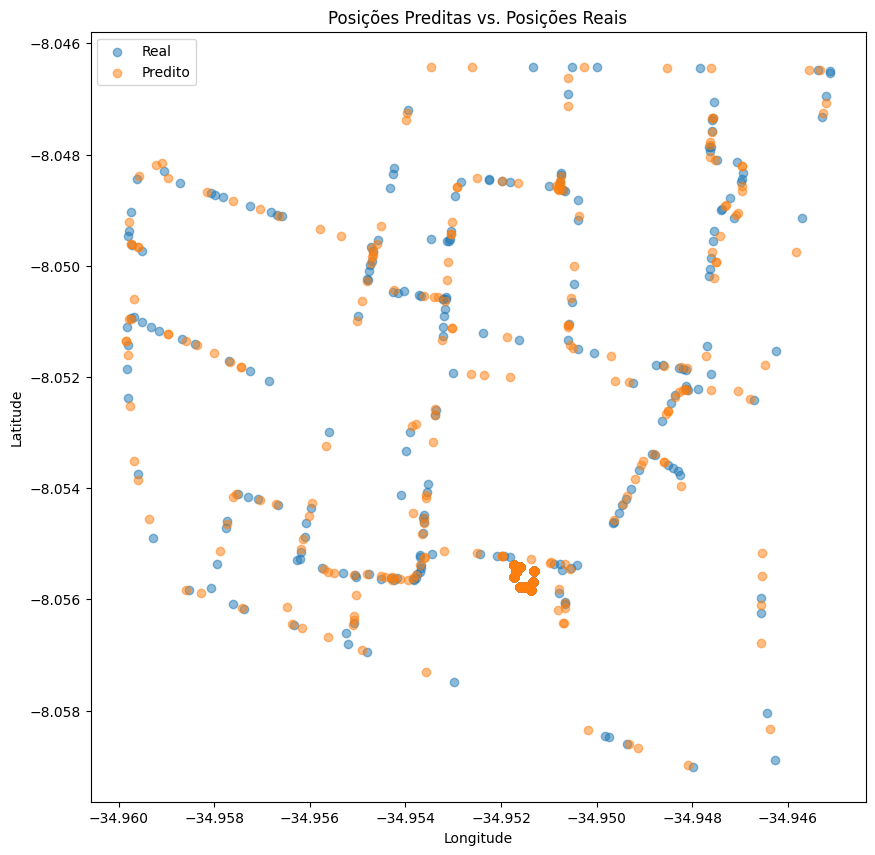

In [69]:
Y_pred_np = np.array(Y_pred)
plt.figure(figsize=(10, 10))
plt.scatter(Y_test['lon'], Y_test['lat'], label='Real', alpha=0.5)
plt.scatter(Y_pred_np[:, 1], Y_pred_np[:, 0], label='Predito', alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Posições Preditas vs. Posições Reais')
plt.legend()
plt.show()

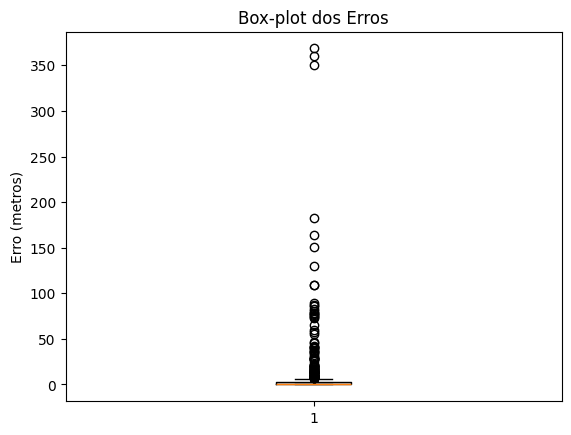

In [70]:

plt.boxplot(compare_df['diferenca_metros'])
plt.ylabel('Erro (metros)')
plt.title('Box-plot dos Erros')
plt.show()


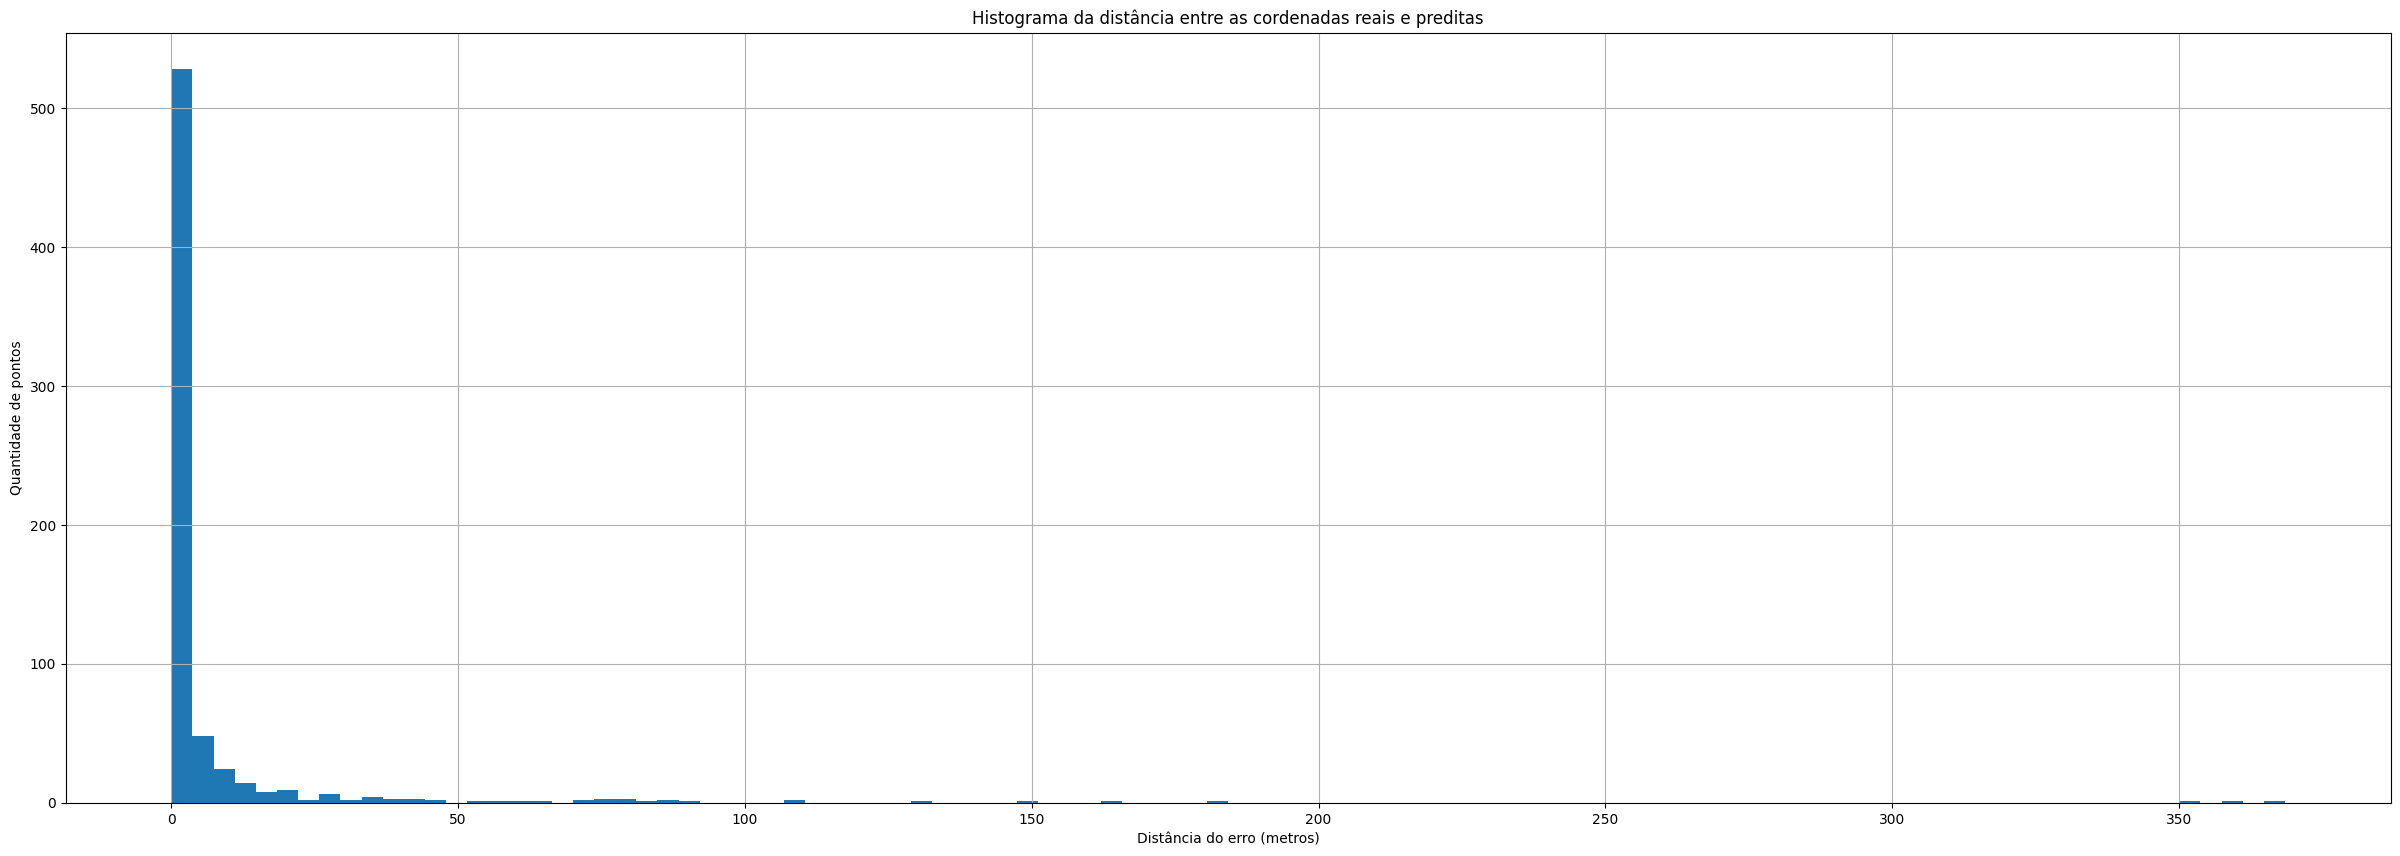

In [71]:
plt.figure(figsize=(30, 10))
plt.hist(compare_df['diferenca_metros'], bins=100)

plt.xlabel('Distância do erro (metros)')
plt.ylabel('Quantidade de pontos')
plt.title('Histograma da distância entre as cordenadas reais e preditas')

plt.grid(True)
plt.show()

In [72]:
compare_df.head()

,ponto_id,lat,lon,lat_pred,lon_pred,lat_diferenca,lon_diferenca,lat_diferenca_metros,lon_diferenca_metros,diferenca_metros
6651,2790,-8.055684,-34.951331,-8.055684,-34.951331,0.00000,0.00000,0.0000,0.0000,0.000000
5192,2040,-8.055494,-34.951316,-8.055494,-34.951316,0.00000,0.00000,0.0000,0.0000,0.000000
6750,7849,-8.052800,-34.948640,-8.052610,-34.948510,-0.00019,-0.00013,-5.8653,-4.0131,7.106808
534,7550,-8.054310,-34.949470,-8.056430,-34.950680,0.00212,0.00121,65.4444,37.3527,75.353790
1345,7105,-8.055530,-34.955300,-8.056460,-34.955100,0.00093,-0.00020,28.7091,-6.1740,29.365468


#### Export de saída (aplicação no db de teste)

In [78]:
meds_teste_alunos = pd.read_csv('../data/meds_test_alunos.csv')
X_test_final = meds_teste_alunos[['ponto_id', 'rssi_1_1', 'rssi_1_2', 'rssi_1_3', 'rssi_2_1', 'rssi_2_2', 'rssi_2_3', 'rssi_3_1', 'rssi_3_2', 'rssi_3_3']]

Y_pred_test = [list(fingerprinting(compare_df,values)) for _,values in X_test_final.iterrows()]

Y_pred_test = np.array(Y_pred_test)

In [80]:
export_df = pd.DataFrame({'ponto_id': X_test_final['ponto_id'], 'lat_pred': Y_pred_test[:, 0], 'lon_pred': Y_pred_test[:, 1]})
export_df.to_csv('../submit_files/Resultados_Equipe04_MetodoFingerprinting.csv', index=False)